In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, Input
from sklearn.metrics import mean_absolute_error

# Load dataset
df = pd.read_csv('/content/station_data_dataverse.csv')

# Handle missing values
df['distance'] = df['distance'].fillna(df['distance'].mean())

# Encode categorical variables
label_encoder = LabelEncoder()
df['weekday'] = label_encoder.fit_transform(df['weekday'])
df['platform'] = label_encoder.fit_transform(df['platform'])

# Define features and target
X = df[
    ['chargeTimeHrs', 'startTime', 'endTime', 'weekday', 'managerVehicle', 'distance'] +
    ['userId', 'stationId', 'locationId']
]
y = df['kwhTotal']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X for CNN + LSTM input
# Adding an extra dimension for Conv1D compatibility
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Define the CNN + LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
y_test_safe = np.where(y_test == 0, 1e-10, y_test)

# Calculate MAPE safely
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test_safe)) * 100

# Print the results
print("RMSE:", rmse)
print("R² Score:", r2)
print("MAE:", mae)
print("MAPE:", mape, "%")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 25.9388 - mae: 4.0215 - val_loss: 9.6002 - val_mae: 1.9635
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2719 - mae: 1.8100 - val_loss: 9.6916 - val_mae: 2.0428
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3952 - mae: 1.8033 - val_loss: 9.5390 - val_mae: 2.0155
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9297 - mae: 1.8318 - val_loss: 9.2217 - val_mae: 1.9169
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7715 - mae: 1.7798 - val_loss: 9.1188 - val_mae: 1.9476
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3160 - mae: 1.7349 - val_loss: 8.4819 - val_mae: 1.8406
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7750 - mae: 1.5776 - val_loss: 6.9024 - val_mae: 1.5335
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8196 - mae: 1.4351 - val_loss: 6.5630 - val_mae: 1.5165
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5288 - mae: 1

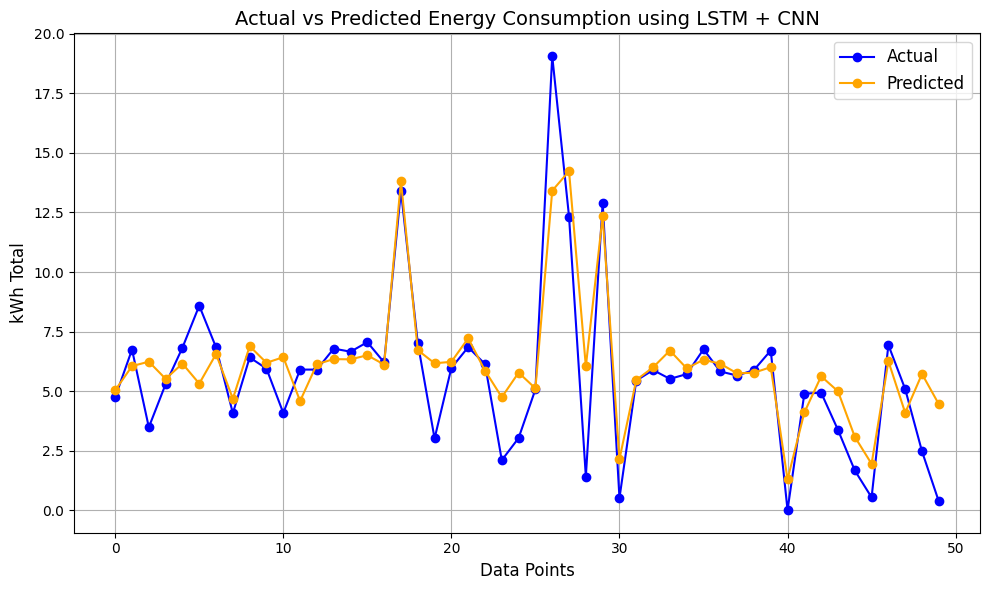

In [ ]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted on the same graph
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test.values[:50], label="Actual", color="blue", marker="o", linestyle="-")

# Plot predicted values
plt.plot(y_pred[:50], label="Predicted", color="orange", marker="o", linestyle="-")

# Add title and labels
plt.title("Actual vs Predicted Energy Consumption using LSTM + CNN", fontsize=14)
plt.xlabel("Data Points", fontsize=12)
plt.ylabel("kWh Total", fontsize=12)

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()